<a href="https://colab.research.google.com/github/Amna1701/alfaisalx-medmnist-challenge/blob/main/notebooks/AlfaisalX_Task1_Task3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Task 1 – CNN Classification on PneumoniaMNIST

This notebook implements a lightweight convolutional neural network (CNN)
for binary classification of chest X-ray images (Normal vs Pneumonia)
using the MedMNIST v2 PneumoniaMNIST dataset.

The implementation runs on CPU and reproduces evaluation metrics,
saves training curves, confusion matrix, ROC curve, failure cases,
and Grad-CAM visualizations under:

reports/task1/

## Environment Setup

In [ ]:
!pip install medmnist torch torchvision scikit-learn tqdm faiss-cpu timm transformers -q

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from medmnist import PneumoniaMNIST
from torchvision import transforms

# Basic transforms (no augmentation yet)
transform = transforms.Compose([
    transforms.ToTensor()
])

# Load splits
train_ds = PneumoniaMNIST(split="train", download=True, transform=transform)
val_ds   = PneumoniaMNIST(split="val",   download=True, transform=transform)
test_ds  = PneumoniaMNIST(split="test",  download=True, transform=transform)

print("Train:", len(train_ds), " Val:", len(val_ds), " Test:", len(test_ds))
print("Example item shapes:")
x, y = train_ds[0]
print("Image tensor shape:", x.shape, " Label:", y, " Label type:", type(y))

Train: 4708  Val: 524  Test: 624
Example item shapes:
Image tensor shape: torch.Size([1, 28, 28])  Label: [1]  Label type: <class 'numpy.ndarray'>


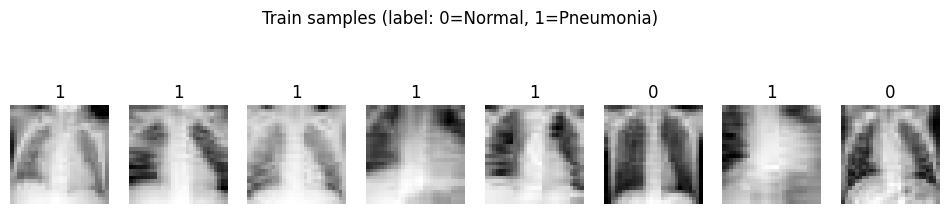

In [ ]:
def show_samples(dataset, n=8, title="Samples"):
    plt.figure(figsize=(12, 3))
    for i in range(n):
        x, y = dataset[i]
        img = x.squeeze(0).numpy()  # (28,28)
        plt.subplot(1, n, i+1)
        plt.imshow(img, cmap="gray")
        plt.title(int(y[0]))
        plt.axis("off")
    plt.suptitle(title)
    plt.show()

show_samples(train_ds, n=8, title="Train samples (label: 0=Normal, 1=Pneumonia)")

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import transforms
from medmnist import PneumoniaMNIST
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [ ]:
train_tf = transforms.Compose([
    transforms.ToTensor(),
    transforms.RandomAffine(degrees=7, translate=(0.05, 0.05), scale=(0.95, 1.05)),
    transforms.Normalize(mean=[0.5], std=[0.5]),
])

test_tf = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5]),
])

train_ds = PneumoniaMNIST(split="train", download=True, transform=train_tf)
val_ds   = PneumoniaMNIST(split="val",   download=True, transform=test_tf)
test_ds  = PneumoniaMNIST(split="test",  download=True, transform=test_tf)

batch_size = 128
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader   = DataLoader(val_ds,   batch_size=batch_size, shuffle=False, num_workers=2)
test_loader  = DataLoader(test_ds,  batch_size=batch_size, shuffle=False, num_workers=2)

len(train_loader), len(val_loader), len(test_loader)

(37, 5, 5)

In [ ]:
class SmallCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 32, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),  # 14x14
            nn.Conv2d(32, 64, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2), # 7x7
            nn.Conv2d(64, 128, 3, padding=1), nn.ReLU(),
            nn.AdaptiveAvgPool2d((1, 1)),
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128, 1)  # output logit
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x.squeeze(1)  # (B,)

model = SmallCNN().to(device)
print(model)

SmallCNN(
  (features): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): AdaptiveAvgPool2d(output_size=(1, 1))
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=128, out_features=1, bias=True)
  )
)


In [ ]:
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="min", factor=0.5, patience=2)

def run_train_epoch(model, loader):
    model.train()
    total_loss = 0
    for x, y in tqdm(loader, leave=False):
        x = x.to(device)
        y = torch.tensor(y).float().to(device).view(-1)  # (B,)
        optimizer.zero_grad()
        logits = model(x)
        loss = loss_fn(logits, y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * x.size(0)
    return total_loss / len(loader.dataset)

@torch.no_grad()
def run_val_epoch(model, loader):
    model.eval()
    total_loss = 0
    for x, y in loader:
        x = x.to(device)
        y = torch.tensor(y).float().to(device).view(-1)
        logits = model(x)
        loss = loss_fn(logits, y)
        total_loss += loss.item() * x.size(0)
    return total_loss / len(loader.dataset)

epochs = 15
train_losses, val_losses = [], []
best_val = float("inf")
best_path = "best_model_task1.pt"

for epoch in range(1, epochs+1):
    tr_loss = run_train_epoch(model, train_loader)
    va_loss = run_val_epoch(model, val_loader)
    scheduler.step(va_loss)

    train_losses.append(tr_loss)
    val_losses.append(va_loss)

    print(f"Epoch {epoch:02d} | train_loss={tr_loss:.4f} | val_loss={va_loss:.4f}")

    if va_loss < best_val:
        best_val = va_loss
        torch.save(model.state_dict(), best_path)

print("Best model saved to:", best_path, "best_val_loss:", best_val)

  0%|          | 0/37 [00:00<?, ?it/s]/tmp/ipython-input-2846689616.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).float().to(device).view(-1)  # (B,)
/tmp/ipython-input-2846689616.py:25: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).float().to(device).view(-1)


Epoch 01 | train_loss=0.5876 | val_loss=0.5592


Epoch 02 | train_loss=0.5090 | val_loss=0.4366


Epoch 03 | train_loss=0.3631 | val_loss=0.3180


Epoch 04 | train_loss=0.2502 | val_loss=0.2835


Epoch 05 | train_loss=0.2307 | val_loss=0.2323


Epoch 06 | train_loss=0.2097 | val_loss=0.2099


Epoch 07 | train_loss=0.2097 | val_loss=0.2089


Epoch 08 | train_loss=0.1889 | val_loss=0.2009


Epoch 09 | train_loss=0.1838 | val_loss=0.2218


Epoch 10 | train_loss=0.1774 | val_loss=0.1832


Epoch 11 | train_loss=0.1724 | val_loss=0.1853


Epoch 12 | train_loss=0.1704 | val_loss=0.1896


Epoch 13 | train_loss=0.1542 | val_loss=0.1593


Epoch 14 | train_loss=0.1538 | val_loss=0.1557


Epoch 15 | train_loss=0.1520 | val_loss=0.1765
Best model saved to: best_model_task1.pt best_val_loss: 0.1557475301714344


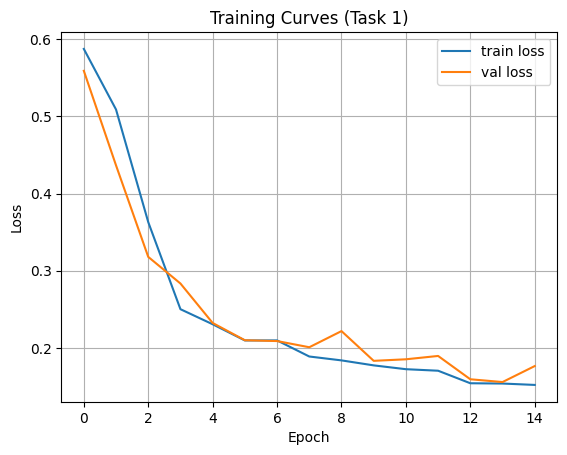

In [ ]:
plt.figure()
plt.plot(train_losses, label="train loss")
plt.plot(val_losses, label="val loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Curves (Task 1)")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.metrics import confusion_matrix, roc_curve
import seaborn as sns

# Load best model
model.load_state_dict(torch.load("best_model_task1.pt"))
model.eval()

all_probs = []
all_labels = []

with torch.no_grad():
    for x, y in test_loader:
        x = x.to(device)
        logits = model(x)
        probs = torch.sigmoid(logits).cpu().numpy()
        all_probs.extend(probs)
        all_labels.extend(y.flatten())

all_probs = np.array(all_probs)
all_labels = np.array(all_labels)

# Predictions
preds = (all_probs >= 0.5).astype(int)

# Metrics
acc = accuracy_score(all_labels, preds)
prec = precision_score(all_labels, preds)
rec = recall_score(all_labels, preds)
f1 = f1_score(all_labels, preds)
auc = roc_auc_score(all_labels, all_probs)

print("Accuracy :", acc)
print("Precision:", prec)
print("Recall   :", rec)
print("F1-score :", f1)
print("AUC      :", auc)

Accuracy : 0.8942307692307693
Precision: 0.8802816901408451
Recall   : 0.9615384615384616
F1-score : 0.9191176470588235
AUC      : 0.950635546789393


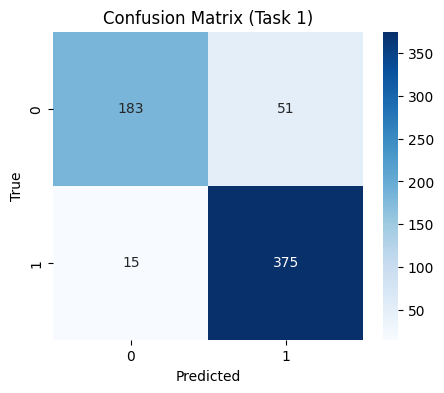

In [ ]:
cm = confusion_matrix(all_labels, preds)

plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix (Task 1)")
plt.show()

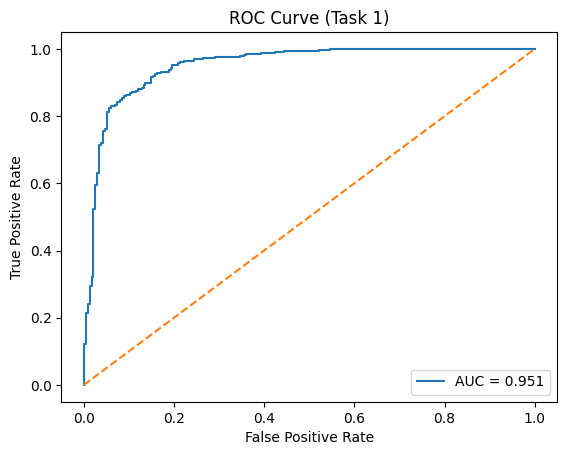

In [ ]:
fpr, tpr, _ = roc_curve(all_labels, all_probs)

plt.figure()
plt.plot(fpr, tpr, label=f"AUC = {auc:.3f}")
plt.plot([0,1],[0,1],'--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (Task 1)")
plt.legend()
plt.show()

In [ ]:
wrong_indices = np.where(preds != all_labels)[0]
len(wrong_indices)

66

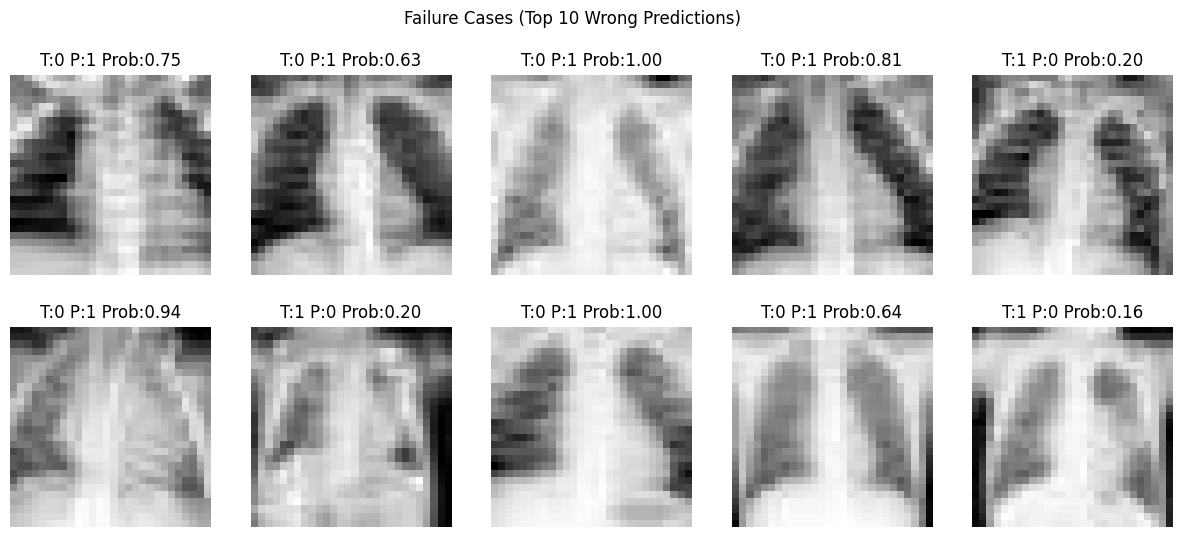

In [ ]:
# Get original (non-augmented) test dataset for visualization
orig_test_ds = PneumoniaMNIST(split="test", download=True, transform=transforms.ToTensor())

plt.figure(figsize=(15,6))

for i in range(10):  # show 10 wrong cases
    idx = wrong_indices[i]
    img, label = orig_test_ds[idx]
    img = img.squeeze(0).numpy()

    prob = all_probs[idx]
    pred = preds[idx]

    plt.subplot(2,5,i+1)
    plt.imshow(img, cmap="gray")
    plt.title(f"T:{int(label[0])} P:{pred} Prob:{prob:.2f}")
    plt.axis("off")

plt.suptitle("Failure Cases (Top 10 Wrong Predictions)")
plt.show()

In [ ]:
import os

os.makedirs("reports/task1", exist_ok=True)

# Save training curves
plt.figure()
plt.plot(train_losses, label="train loss")
plt.plot(val_losses, label="val loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Curves (Task 1)")
plt.legend()
plt.grid(True)
plt.savefig("reports/task1/training_curves.png", dpi=300)
plt.close()

# Save confusion matrix
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix (Task 1)")
plt.savefig("reports/task1/confusion_matrix.png", dpi=300)
plt.close()

# Save ROC curve
plt.figure()
plt.plot(fpr, tpr, label=f"AUC = {auc:.3f}")
plt.plot([0,1],[0,1],'--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (Task 1)")
plt.legend()
plt.savefig("reports/task1/roc_curve.png", dpi=300)
plt.close()

print("All figures saved in reports/task1/")

All figures saved in reports/task1/


In [ ]:
import json

metrics = {
    "accuracy": float(acc),
    "precision": float(prec),
    "recall": float(rec),
    "f1_score": float(f1),
    "auc": float(auc)
}

with open("reports/task1/test_metrics.json", "w") as f:
    json.dump(metrics, f, indent=4)

metrics

{'accuracy': 0.8942307692307693,
 'precision': 0.8802816901408451,
 'recall': 0.9615384615384616,
 'f1_score': 0.9191176470588235,
 'auc': 0.950635546789393}

In [ ]:
plt.figure(figsize=(15,6))

for i in range(10):
    idx = wrong_indices[i]
    img, label = orig_test_ds[idx]
    img = img.squeeze(0).numpy()

    prob = all_probs[idx]
    pred = preds[idx]

    plt.subplot(2,5,i+1)
    plt.imshow(img, cmap="gray")
    plt.title(f"T:{int(label[0])} P:{pred} Prob:{prob:.2f}")
    plt.axis("off")

plt.suptitle("Failure Cases (Top 10 Wrong Predictions)")
plt.savefig("reports/task1/failure_cases.png", dpi=300)
plt.close()

print("Failure cases saved.")

Failure cases saved.


# Task 2 — Report Generation (VLM)

In [22]:
!pip -q uninstall -y transformers
!pip -q install "transformers==4.41.2" accelerate sentencepiece protobuf

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.8/43.8 kB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.1/9.1 MB 53.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 566.4/566.4 kB 21.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 66.3 MB/s eta 0:00:00


In [24]:
import transformers
print(transformers.__version__)

5.0.0
